In [1]:
import pandas as pd
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import matplotlib

# Load coordinates

In [2]:
corners_regions_byrd = pd.read_csv("/home/kim/ice_thickness/data/real_data/corners_byrd_regions.csv")
corners_regions_byrd

,name,x_min,x_max,y_min,y_max
0,region_Byrd,350000,650000,-1000000,-700000
1,region_upper_byrd,400000,470000,-800000,-730000
2,region_mid_byrd,395000,465000,-870000,-800000
3,region_lower_byrd,420000,450000,-910000,-880000


## Load Bedmap3

Overview of data sets: https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=2d0e4791-8e20-46a3-80e4-f5f6716025d2 

Load smaller tiff file with ice thickness only:  
wget https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=2d0e4791-8e20-46a3-80e4-f5f6716025d2

Load full Bedmap3 data set (2.32 GB):  
wget https://ramadda.data.bas.ac.uk/repository/entry/get/bedmap3.nc?entryid=synth%3A2d0e4791-8e20-46a3-80e4-f5f6716025d2%3AL2JlZG1hcDMubmM%3D

In [3]:
# wget https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=2d0e4791-8e20-46a3-80e4-f5f6716025d2
# wget https://ramadda.data.bas.ac.uk/repository/entry/get/bedmap3.nc?entryid=synth%3A2d0e4791-8e20-46a3-80e4-f5f6716025d2%3AL2JlZG1hcDMubmM%3D

In [4]:
bm3 = xr.open_dataset("/home/kim//data/bedmap3/bedmap3.nc")

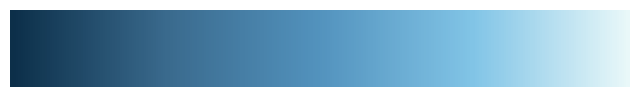

In [5]:
# Use the same colormap as in the Bedmap3 paper: https://www.nature.com/articles/s41597-025-04672-y/figures/7
values = np.array([0., 0.25, 0.5, 0.75, 1.])
# colors = ["#396a90", "#5986a7", "#83a8c0", "#accad9", "#dff4f6"]
# However, we increase vibrancy a bit
colors = ["#0c2f49", "#3a6a8d", "#5393be", "#82c5e7", "#e9f8f9"]
bedmap_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name = "error_cmap", colors = list(zip(values, colors)))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = bedmap_cmap)
plt.axis('off')

plt.savefig(f"figures/cmaps/bedmap.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()

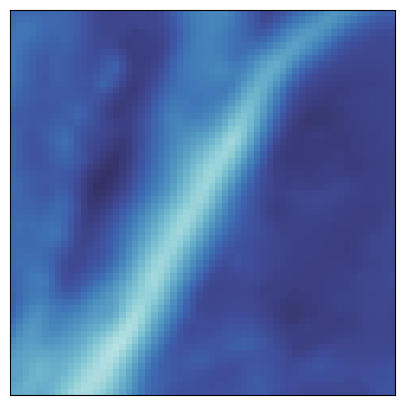

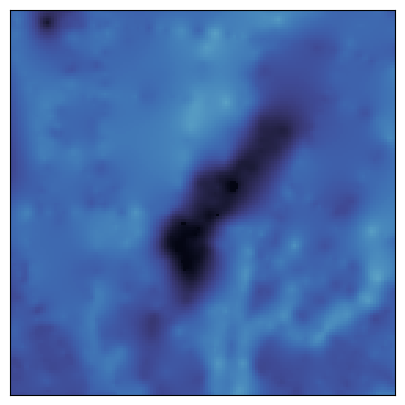

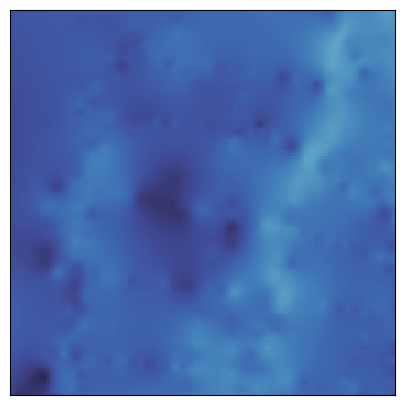

In [6]:
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    region_specs = corners_regions_byrd[corners_regions_byrd["name"] == region].iloc[0]

    bedmap3_region_subset = bm3.sel(
        x = slice(region_specs["x_min"], region_specs["x_max"]),
        y = slice(region_specs["y_max"], region_specs["y_min"])  # y goes from top to bottom (more positive to more negative)
    )

    # Extract 2D data and coordinates
    Z = bedmap3_region_subset.ice_thickness.values
    X = bedmap3_region_subset.x.values
    Y = bedmap3_region_subset.y.values

    # Create 2D coordinate grids
    X2D, Y2D = np.meshgrid(X, Y)

    # Plot with pcolor
    plt.figure(figsize = (6, 5))
    plt.pcolormesh(X2D, Y2D, Z, shading = 'auto', cmap = cmocean.cm.ice, vmin = 0, vmax = 3600)

    plt.gca().set_aspect('equal')

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    plt.savefig(f"/home/kim/ice_thickness/figures_real/bedmap3/{region}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

# Load Bedmachine

In [7]:
bedmachine = xr.open_dataset("/home/kim/data/nsidc/BedMachineAntarctica-v3.nc")

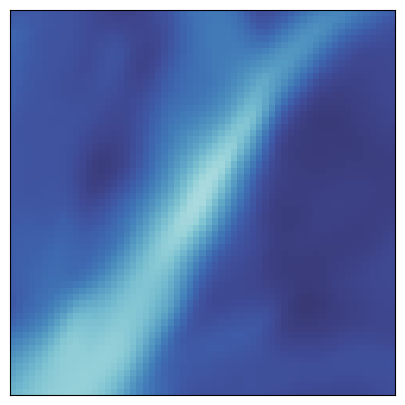

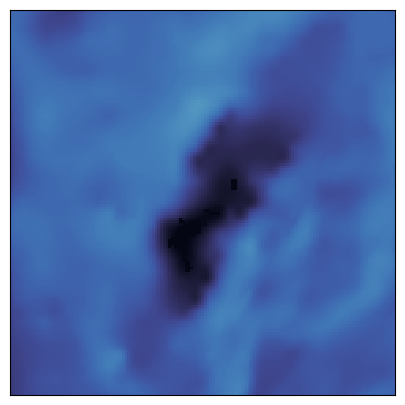

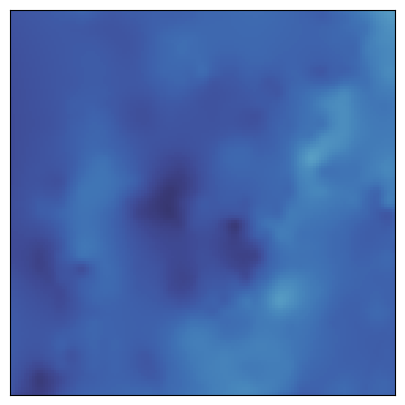

In [8]:
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    region_specs = corners_regions_byrd[corners_regions_byrd["name"] == region].iloc[0]

    bedmachine_region_subset = bedmachine.sel(
        x = slice(region_specs["x_min"], region_specs["x_max"]),
        y = slice(region_specs["y_max"], region_specs["y_min"])  # y goes from top to bottom (more positive to more negative)
    )

    # bedmap3_region_subset.ice_thickness.plot()

    # Extract 2D data and coordinates
    # NOTE: In Bedmachine it is just called "thickness"
    Z = bedmachine_region_subset.thickness.values
    X = bedmachine_region_subset.x.values
    Y = bedmachine_region_subset.y.values

    # Create 2D coordinate grids
    X2D, Y2D = np.meshgrid(X, Y)

    # Plot with pcolor
    plt.figure(figsize = (6, 5))
    plt.pcolormesh(X2D, Y2D, Z, shading = 'auto', cmap = cmocean.cm.ice, vmin = 0, vmax = 3600)

    plt.gca().set_aspect('equal')

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    plt.savefig(f"/home/kim/ice_thickness/figures_real/bedmachine/{region}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

# Add MODIS

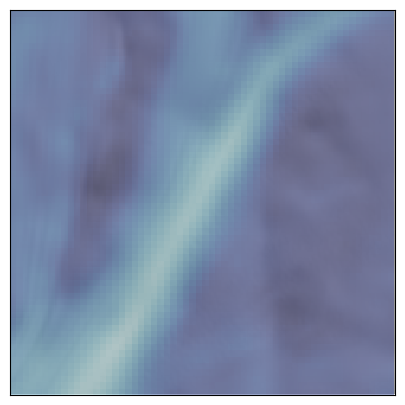

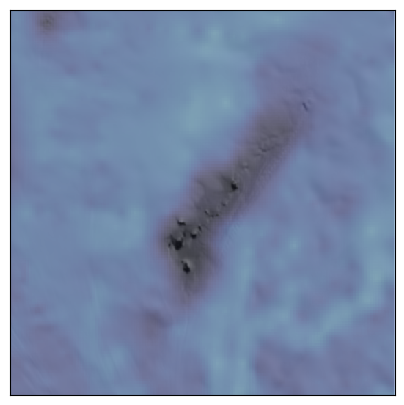

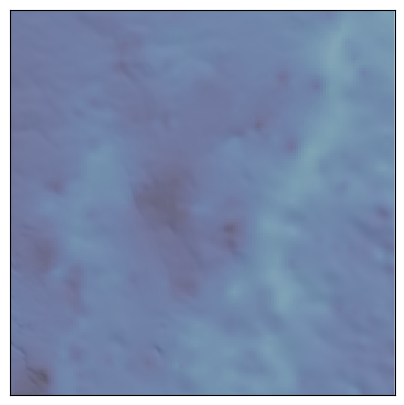

In [9]:
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    # Load MODIS data
    modis_file_path = "data/modis/modis" + region[6:] + ".pt"
    modis = torch.load(modis_file_path, weights_only = False)

    region_specs = corners_regions_byrd[corners_regions_byrd["name"] == region].iloc[0]

    bedmap3_region_subset = bm3.sel(
        x = slice(region_specs["x_min"], region_specs["x_max"]),
        y = slice(region_specs["y_max"], region_specs["y_min"])  # y goes from top to bottom (more positive to more negative)
    )

    # Extract 2D data and coordinates
    Z = bedmap3_region_subset.ice_thickness.values
    X = bedmap3_region_subset.x.values
    Y = bedmap3_region_subset.y.values

    # Create 2D coordinate grids
    X2D, Y2D = np.meshgrid(X, Y)

    # Plot with pcolor
    plt.figure(figsize = (6, 5))

    plt.pcolormesh(modis[0], modis[1], modis[2], vmin = 0, vmax = 25_000, cmap = "gray")
    plt.pcolormesh(X2D, Y2D, Z, shading = 'auto', cmap = cmocean.cm.ice, vmin = 0, vmax = 3_600, alpha = 0.5)

    plt.gca().set_aspect('equal')

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    plt.savefig(f"/home/kim/ice_thickness/figures_real/bedmap3/modis_{region}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

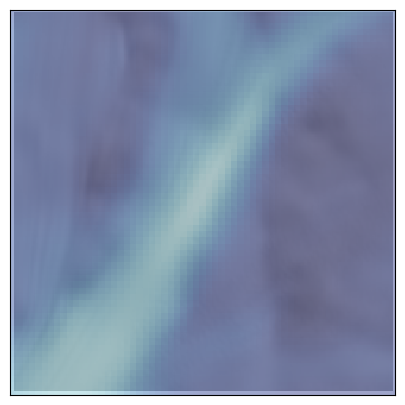

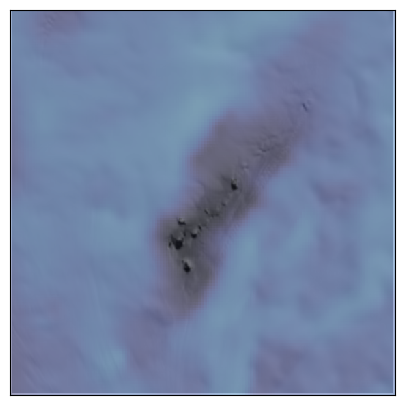

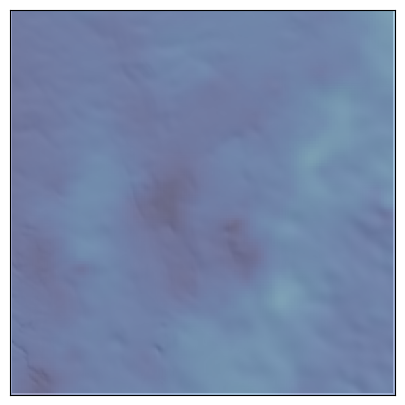

In [12]:
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    # Load MODIS data
    modis_file_path = "data/modis/modis" + region[6:] + ".pt"
    modis = torch.load(modis_file_path, weights_only = False)

    region_specs = corners_regions_byrd[corners_regions_byrd["name"] == region].iloc[0]

    bedmachine_region_subset = bedmachine.sel(
        x = slice(region_specs["x_min"], region_specs["x_max"]),
        y = slice(region_specs["y_max"], region_specs["y_min"])  # y goes from top to bottom (more positive to more negative)
    )

    # Extract 2D data and coordinates
    Z = bedmachine_region_subset.thickness.values
    X = bedmachine_region_subset.x.values
    Y = bedmachine_region_subset.y.values

    # Create 2D coordinate grids
    X2D, Y2D = np.meshgrid(X, Y)

    # Plot with pcolor
    plt.figure(figsize = (6, 5))

    plt.pcolormesh(modis[0], modis[1], modis[2], vmin = 0, vmax = 25_000, cmap = "gray")
    plt.pcolormesh(X2D, Y2D, Z, shading = 'auto', cmap = cmocean.cm.ice, vmin = 0, vmax = 3_600, alpha = 0.5)

    plt.gca().set_aspect('equal')

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    plt.savefig(f"/home/kim/ice_thickness/figures_real/bedmachine/modis_{region}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    plt.show()